# 1. MPC

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import solve_discrete_are, inv
import cvxpy as cp
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches

In [18]:
# Model parameters
g = 9.81  # m/s^2
m = 1.0   # kg 
l = 0.3   # meters
J = 0.2 * m * l * l

# Thrust limits
umin = np.array([0.2 * m * g, 0.2 * m * g])
umax = np.array([0.6 * m * g, 0.6 * m * g])

h = 0.05  # time step (20 Hz)

In [19]:
# Planar Quadrotor Dynamics
# ẋ = f(x, u)
def quad_dynamics(x, u):
    """
    State: x = [x, y, θ, ẋ, ẏ, θ̇]
    Control: u = [u1, u2] (thrust from left and right rotors)
    """
    theta = x[2]
    
    x_ddot = (1/m) * (u[0] + u[1]) * np.sin(theta)
    y_ddot = (1/m) * (u[0] + u[1]) * np.cos(theta) - g
    theta_ddot = (1/J) * (l/2) * (u[1] - u[0])
    
    return np.array([x[3], x[4], x[5], x_ddot, y_ddot, theta_ddot])

In [20]:
def quad_dynamics_rk4(x, u):
    """
    RK4 integration with zero-order hold on u
    """
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    return x + (h/6.0) * (f1 + 2*f2 + 2*f3 + f4)

In [21]:
# Linearized dynamics for hovering
x_hover = np.zeros(6)
u_hover = np.array([0.5*m*g, 0.5*m*g])

# Numerical differentiation for Jacobians
def compute_jacobians():
    eps = 1e-6
    
    # A matrix (∂f/∂x)
    A = np.zeros((6, 6))
    for i in range(6):
        x_plus = x_hover.copy()
        x_minus = x_hover.copy()
        x_plus[i] += eps
        x_minus[i] -= eps
        A[:, i] = (quad_dynamics_rk4(x_plus, u_hover) - quad_dynamics_rk4(x_minus, u_hover)) / (2*eps)
    
    # B matrix (∂f/∂u)
    B = np.zeros((6, 2))
    for i in range(2):
        u_plus = u_hover.copy()
        u_minus = u_hover.copy()
        u_plus[i] += eps
        u_minus[i] -= eps
        B[:, i] = (quad_dynamics_rk4(x_hover, u_plus) - quad_dynamics_rk4(x_hover, u_minus)) / (2*eps)
    
    return A, B

A, B = compute_jacobians()

# Verify equilibrium point
print("Equilibrium check:", quad_dynamics_rk4(x_hover, u_hover))
print("A matrix shape:", A.shape)
print("B matrix shape:", B.shape)

Equilibrium check: [0. 0. 0. 0. 0. 0.]
A matrix shape: (6, 6)
B matrix shape: (6, 2)


In [22]:
# Simulation parameters
Nx = 6     # number of states
Nu = 2     # number of controls
Tfinal = 10.0  # final time
Nt = int(Tfinal/h) + 1    # number of time steps
thist = np.arange(0, h*Nt, h)

# Cost weights
Q = np.eye(Nx)
R = 0.01 * np.eye(Nu)
Qn = np.eye(Nx)

print(f"Simulation time steps: {Nt}")
print(f"Time vector length: {len(thist)}")

Simulation time steps: 201
Time vector length: 201


In [23]:
# Cost function
def cost(xhist, uhist):
    """
    Calculate total cost for trajectory
    """
    total_cost = 0.5 * xhist[:, -1].T @ Qn @ xhist[:, -1]
    
    for k in range(xhist.shape[1] - 1):
        total_cost += 0.5 * xhist[:, k].T @ Q @ xhist[:, k] + 0.5 * uhist[:, k].T @ R @ uhist[:, k]
    
    return total_cost

In [24]:
# LQR Hover Controller
def dlqr(A, B, Q, R):
    """
    Solve discrete-time LQR problem
    """
    # Solve discrete algebraic Riccati equation
    P = solve_discrete_are(A, B, Q, R)
    
    # Compute LQR gain
    K = inv(R + B.T @ P @ B) @ (B.T @ P @ A)
    
    return K, P

K, P = dlqr(A, B, Q, R)

def lqr_controller(t, x, K, xref):
    """
    LQR controller
    """
    return u_hover - K @ (x - xref)

print("LQR gain K shape:", K.shape)
print("Riccati solution P shape:", P.shape)

LQR gain K shape: (2, 6)
Riccati solution P shape: (6, 6)


In [25]:
# MPC Controller
Nh = 20  # horizon length (one second at 20Hz)

class MPCController:
    def __init__(self, A, B, Q, R, P, Nh, umin, umax, u_hover):
        self.A = A
        self.B = B
        self.Q = Q
        self.R = R
        self.P = P
        self.Nh = Nh
        self.umin = umin
        self.umax = umax
        self.u_hover = u_hover
        self.Nx = A.shape[0]
        self.Nu = B.shape[1]
        
    def solve_mpc(self, x0, xref):
        """
        Solve MPC optimization problem using CVXPY
        """
        # Decision variables
        x = cp.Variable((self.Nx, self.Nh+1))
        u = cp.Variable((self.Nu, self.Nh))
        
        # Cost function
        cost = 0
        constraints = []
        
        # Initial condition
        constraints += [x[:, 0] == x0]
        
        # Stage costs and dynamics constraints
        for k in range(self.Nh):
            # Stage cost
            if k < self.Nh - 1:
                cost += cp.quad_form(x[:, k] - xref, self.Q) + cp.quad_form(u[:, k], self.R)
            
            # Dynamics constraint
            constraints += [x[:, k+1] == self.A @ x[:, k] + self.B @ u[:, k]]
            
            # Control constraints
            constraints += [self.umin - self.u_hover <= u[:, k]]
            constraints += [u[:, k] <= self.umax - self.u_hover]
        
        # Terminal cost
        cost += cp.quad_form(x[:, self.Nh] - xref, self.P)
        
        # Solve optimization problem
        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve(solver=cp.OSQP, verbose=False)
        
        if prob.status not in ["infeasible", "unbounded"]:
            return u.value[:, 0] + self.u_hover
        else:
            print(f"MPC solver failed with status: {prob.status}")
            return self.u_hover

mpc = MPCController(A, B, Q, R, P, Nh, umin, umax, u_hover)

def mpc_controller(t, x, xref):
    """
    MPC controller function
    """
    return mpc.solve_mpc(x, xref)

In [26]:
def closed_loop(x0, controller, N, xref):
    """
    Simulate closed-loop system
    """
    xhist = np.zeros((len(x0), N))
    u0 = controller(0, x0, xref)
    uhist = np.zeros((len(u0), N-1))
    
    xhist[:, 0] = x0
    
    for k in range(N-1):
        uk = controller(k, xhist[:, k], xref)
        # Enforce control limits
        uk = np.clip(uk, umin, umax)
        uhist[:, k] = uk
        xhist[:, k+1] = quad_dynamics_rk4(xhist[:, k], uk)
        
        if k % 50 == 0:  # Print progress every 50 steps
            print(f"Step {k}: x = {xhist[:, k]}, u = {uk}")
    
    return xhist, uhist

In [27]:
# Set reference and initial conditions
x_ref = np.array([0.0, 1.0, 0.0, 1.0, 1.0, 1.0])
x0 = np.array([1.0, 2.0, 0.0, 0.0, 0.0, 0.0])

print("Reference state:", x_ref)
print("Initial state:", x0)
print("Hovering input:", u_hover)

# Run LQR simulation
print("\nRunning LQR simulation...")
xhist1, uhist1 = closed_loop(x0, 
                            lambda t, x, xref: lqr_controller(t, x, K, xref), 
                            Nt, x_ref)

print(f"LQR simulation completed. Final state: {xhist1[:, -1]}")
print(f"LQR cost: {cost(xhist1, uhist1)}")

Reference state: [0. 1. 0. 1. 1. 1.]
Initial state: [1. 2. 0. 0. 0. 0.]
Hovering input: [4.905 4.905]

Running LQR simulation...
Step 0: x = [1. 2. 0. 0. 0. 0.], u = [3.54197475 5.886     ]
Step 50: x = [ 2.57137792  2.08598227 -0.02645864  0.23364843  0.01127114  0.0375336 ], u = [4.90524279 4.89809594]
Step 100: x = [ 2.78499519e+00  2.09669281e+00 -1.99682605e-03  1.94467172e-02
  9.79187292e-04  2.02836054e-03], u = [4.90465196 4.90441344]
Step 150: x = [ 2.80281558e+00  2.09759190e+00 -1.62544096e-04  1.59411561e-03
  8.01827980e-05  1.62525581e-04], u = [4.90497036 4.90495137]
LQR simulation completed. Final state: [ 2.80427867e+00  2.09766537e+00 -1.33369418e-05  1.30834631e-04
  6.53932923e-06  1.33338017e-05]
LQR cost: 1171.241272629313


In [28]:
# Run MPC simulation
print("\nRunning MPC simulation...")
xhist2, uhist2 = closed_loop(x0, 
                            lambda t, x, xref: mpc_controller(t, x, xref), 
                            Nt, x_ref)

print(f"MPC simulation completed. Final state: {xhist2[:, -1]}")
print(f"MPC cost: {cost(xhist2, uhist2)}")


Running MPC simulation...
Step 0: x = [1. 2. 0. 0. 0. 0.], u = [3.06158146 1.962     ]
Step 50: x = [ 0.50835289  1.48607577  0.00797056 -0.07423543 -0.05163458 -0.01089456], u = [4.92888042 4.93101348]
Step 50: x = [ 0.50835289  1.48607577  0.00797056 -0.07423543 -0.05163458 -0.01089456], u = [4.92888042 4.93101348]
Step 100: x = [ 4.38662375e-01  1.43804869e+00  6.61572558e-04 -6.58214944e-03
 -4.42364767e-03 -6.58133577e-04], u = [4.90708346 4.90715969]
Step 150: x = [ 4.32535586e-01  1.43393131e+00  5.66638319e-05 -5.66582569e-04
 -3.79442508e-04 -5.55730369e-05], u = [4.9051787  4.90518507]
MPC simulation completed. Final state: [ 4.32007761e-01  1.43357812e+00  4.87709942e-06 -4.87733586e-05
 -3.25502143e-05 -4.78308421e-06]
MPC cost: 307.54224839146644


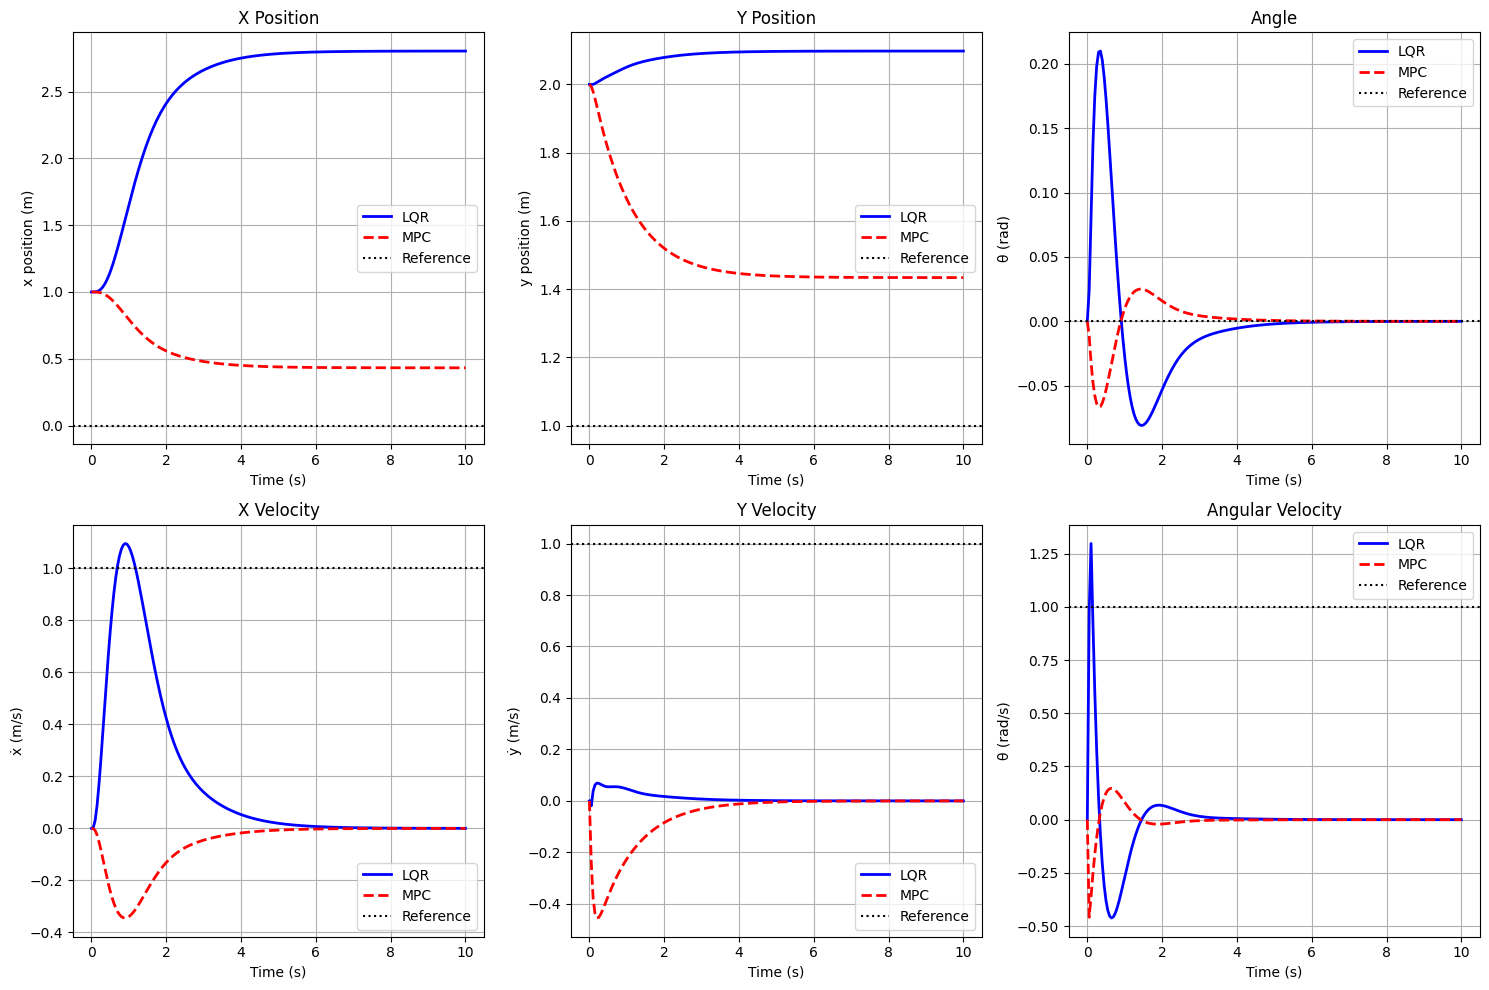

In [29]:
# Plot results
plt.figure(figsize=(15, 10))

# Position plots
plt.subplot(2, 3, 1)
plt.plot(thist, xhist1[0, :], 'b-', label='LQR', linewidth=2)
plt.plot(thist, xhist2[0, :], 'r--', label='MPC', linewidth=2)
plt.axhline(y=x_ref[0], color='k', linestyle=':', label='Reference')
plt.xlabel('Time (s)')
plt.ylabel('x position (m)')
plt.title('X Position')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(thist, xhist1[1, :], 'b-', label='LQR', linewidth=2)
plt.plot(thist, xhist2[1, :], 'r--', label='MPC', linewidth=2)
plt.axhline(y=x_ref[1], color='k', linestyle=':', label='Reference')
plt.xlabel('Time (s)')
plt.ylabel('y position (m)')
plt.title('Y Position')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(thist, xhist1[2, :], 'b-', label='LQR', linewidth=2)
plt.plot(thist, xhist2[2, :], 'r--', label='MPC', linewidth=2)
plt.axhline(y=x_ref[2], color='k', linestyle=':', label='Reference')
plt.xlabel('Time (s)')
plt.ylabel('θ (rad)')
plt.title('Angle')
plt.legend()
plt.grid(True)

# Velocity plots
plt.subplot(2, 3, 4)
plt.plot(thist, xhist1[3, :], 'b-', label='LQR', linewidth=2)
plt.plot(thist, xhist2[3, :], 'r--', label='MPC', linewidth=2)
plt.axhline(y=x_ref[3], color='k', linestyle=':', label='Reference')
plt.xlabel('Time (s)')
plt.ylabel('ẋ (m/s)')
plt.title('X Velocity')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(thist, xhist1[4, :], 'b-', label='LQR', linewidth=2)
plt.plot(thist, xhist2[4, :], 'r--', label='MPC', linewidth=2)
plt.axhline(y=x_ref[4], color='k', linestyle=':', label='Reference')
plt.xlabel('Time (s)')
plt.ylabel('ẏ (m/s)')
plt.title('Y Velocity')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(thist, xhist1[5, :], 'b-', label='LQR', linewidth=2)
plt.plot(thist, xhist2[5, :], 'r--', label='MPC', linewidth=2)
plt.axhline(y=x_ref[5], color='k', linestyle=':', label='Reference')
plt.xlabel('Time (s)')
plt.ylabel('θ̇ (rad/s)')
plt.title('Angular Velocity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

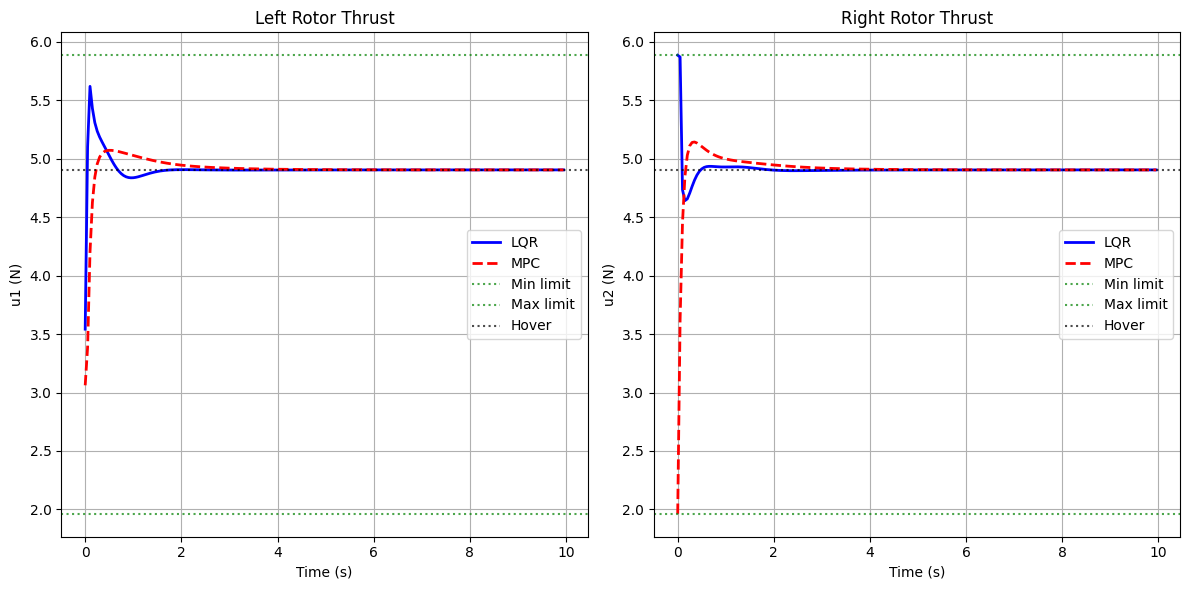

In [30]:
# Plot control inputs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(thist[:-1], uhist1[0, :], 'b-', label='LQR', linewidth=2)
plt.plot(thist[:-1], uhist2[0, :], 'r--', label='MPC', linewidth=2)
plt.axhline(y=umin[0], color='g', linestyle=':', alpha=0.7, label='Min limit')
plt.axhline(y=umax[0], color='g', linestyle=':', alpha=0.7, label='Max limit')
plt.axhline(y=u_hover[0], color='k', linestyle=':', alpha=0.7, label='Hover')
plt.xlabel('Time (s)')
plt.ylabel('u1 (N)')
plt.title('Left Rotor Thrust')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thist[:-1], uhist1[1, :], 'b-', label='LQR', linewidth=2)
plt.plot(thist[:-1], uhist2[1, :], 'r--', label='MPC', linewidth=2)
plt.axhline(y=umin[1], color='g', linestyle=':', alpha=0.7, label='Min limit')
plt.axhline(y=umax[1], color='g', linestyle=':', alpha=0.7, label='Max limit')
plt.axhline(y=u_hover[1], color='k', linestyle=':', alpha=0.7, label='Hover')
plt.xlabel('Time (s)')
plt.ylabel('u2 (N)')
plt.title('Right Rotor Thrust')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

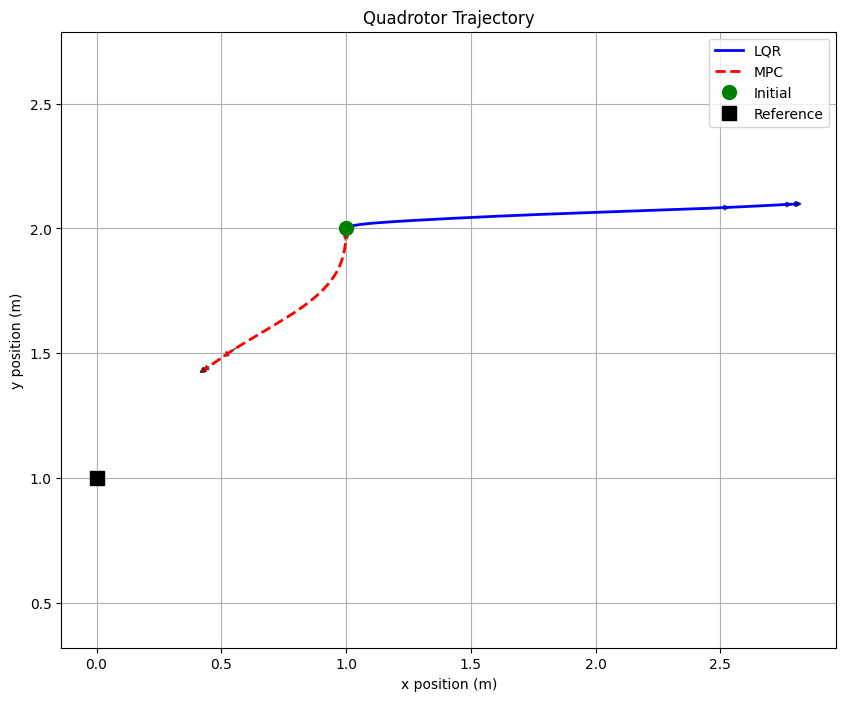

In [31]:
# Plot trajectory in x-y plane
plt.figure(figsize=(10, 8))
plt.plot(xhist1[0, :], xhist1[1, :], 'b-', label='LQR', linewidth=2)
plt.plot(xhist2[0, :], xhist2[1, :], 'r--', label='MPC', linewidth=2)
plt.plot(x0[0], x0[1], 'go', markersize=10, label='Initial')
plt.plot(x_ref[0], x_ref[1], 'ks', markersize=10, label='Reference')

# Add direction arrows
for i in range(0, len(thist), 40):
    if i < len(thist) - 1:
        dx1, dy1 = xhist1[0, i+1] - xhist1[0, i], xhist1[1, i+1] - xhist1[1, i]
        dx2, dy2 = xhist2[0, i+1] - xhist2[0, i], xhist2[1, i+1] - xhist2[1, i]
        plt.arrow(xhist1[0, i], xhist1[1, i], dx1*5, dy1*5, 
                 head_width=0.02, head_length=0.02, fc='blue', alpha=0.6)
        plt.arrow(xhist2[0, i], xhist2[1, i], dx2*5, dy2*5, 
                 head_width=0.02, head_length=0.02, fc='red', alpha=0.6)

plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.title('Quadrotor Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [ ]:
# Setup for animations in Jupyter
import matplotlib
print(f"Matplotlib backend: {matplotlib.get_backend()}")

# Try to set interactive backend
try:
    %matplotlib widget
    print("Using widget backend for interactive animations")
except:
    try:
        %matplotlib notebook
        print("Using notebook backend for interactive animations")
    except:
        %matplotlib inline
        print("Using inline backend - animations will be static")

# Install ipywidgets if not available (uncomment if needed)
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

Creating LQR animation...
Showing LQR static frames...


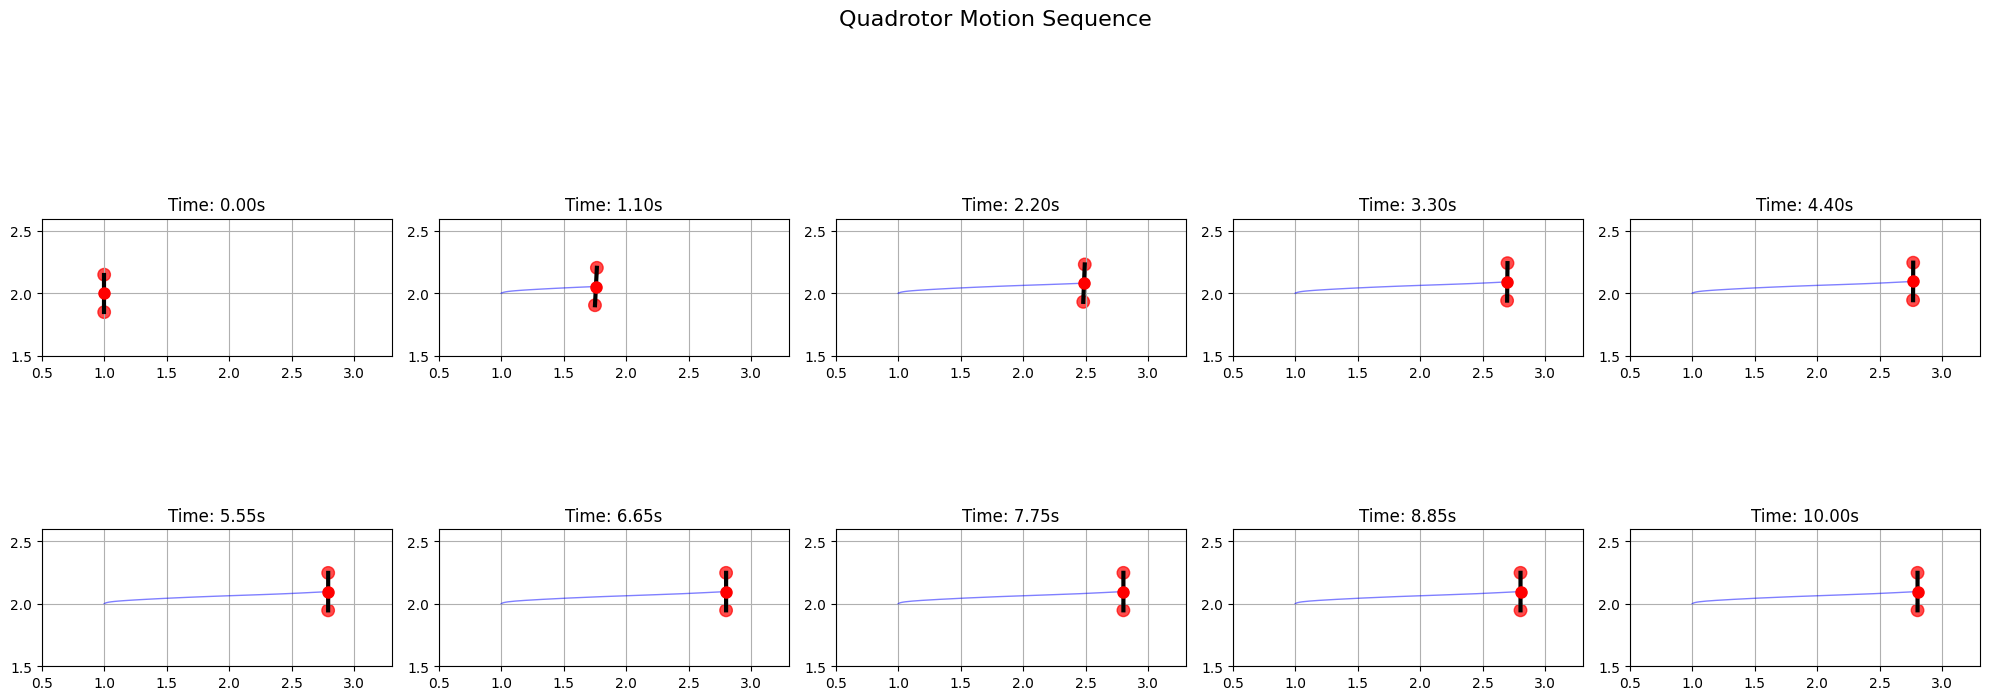

In [36]:
# Setup matplotlib for animations - use inline backend for VS Code
%matplotlib inline

# Quadrotor Animation
class QuadrotorAnimator:
    def __init__(self, xhist, thist, l=0.3):
        self.xhist = xhist
        self.thist = thist
        self.l = l  # quadrotor arm length
        
    def animate(self, save_gif=False, filename='quadrotor_animation.gif'):
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Set up the plot
        x_min, x_max = np.min(self.xhist[0, :]) - 0.5, np.max(self.xhist[0, :]) + 0.5
        y_min, y_max = np.min(self.xhist[1, :]) - 0.5, np.max(self.xhist[1, :]) + 0.5
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_aspect('equal')
        ax.grid(True)
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.set_title('Quadrotor Animation')
        
        # Initialize plot elements
        trajectory_line, = ax.plot([], [], 'b-', alpha=0.5, linewidth=1, label='Trajectory')
        quad_body, = ax.plot([], [], 'k-', linewidth=3, label='Quadrotor')
        left_rotor = patches.Circle((0, 0), 0.05, color='red', alpha=0.7)
        right_rotor = patches.Circle((0, 0), 0.05, color='red', alpha=0.7)
        ax.add_patch(left_rotor)
        ax.add_patch(right_rotor)
        
        center_dot, = ax.plot([], [], 'ro', markersize=8)
        time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, 
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add legend
        ax.legend(loc='upper right')
        
        def animate_frame(i):
            # Ensure we don't go out of bounds
            if i >= len(self.thist):
                i = len(self.thist) - 1
                
            # Current state
            x, y, theta = self.xhist[0, i], self.xhist[1, i], self.xhist[2, i]
            
            # Update trajectory
            trajectory_line.set_data(self.xhist[0, :i+1], self.xhist[1, :i+1])
            
            # Update quadrotor position and orientation
            arm_x = self.l/2 * np.cos(theta + np.pi/2)
            arm_y = self.l/2 * np.sin(theta + np.pi/2)
            
            # Quadrotor body (line between rotors)
            body_x = [x - arm_x, x + arm_x]
            body_y = [y - arm_y, y + arm_y]
            quad_body.set_data(body_x, body_y)
            
            # Rotor positions
            left_rotor.center = (x - arm_x, y - arm_y)
            right_rotor.center = (x + arm_x, y + arm_y)
            
            # Center dot
            center_dot.set_data([x], [y])
            
            # Time text
            time_text.set_text(f'Time: {self.thist[i]:.2f}s')
            
            return trajectory_line, quad_body, left_rotor, right_rotor, center_dot, time_text
        
        # Create animation with slower speed for better visualization
        anim = FuncAnimation(fig, animate_frame, frames=len(self.thist), 
                           interval=100, blit=False, repeat=True)
        
        if save_gif:
            print(f"Saving animation as {filename}...")
            try:
                anim.save(filename, writer='pillow', fps=10)
                print(f"Animation saved as {filename}")
            except Exception as e:
                print(f"Failed to save GIF: {e}")
                print("You may need to install pillow: pip install pillow")
        
        plt.tight_layout()
        
        # Since interactive animation may not work in VS Code, show static frames
        print("Note: Interactive animations may not work in VS Code.")
        print("Showing static frames instead...")
        plt.close(fig)  # Close the animation figure
        return anim
    
    def create_static_frames(self, num_frames=10):
        """
        Create static frames showing the quadrotor at different time points
        """
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()
        
        # Select time indices for frames
        time_indices = np.linspace(0, len(self.thist)-1, num_frames, dtype=int)
        
        for idx, ax in enumerate(axes):
            i = time_indices[idx]
            
            # Current state
            x, y, theta = self.xhist[0, i], self.xhist[1, i], self.xhist[2, i]
            
            # Set up the plot
            x_min, x_max = np.min(self.xhist[0, :]) - 0.5, np.max(self.xhist[0, :]) + 0.5
            y_min, y_max = np.min(self.xhist[1, :]) - 0.5, np.max(self.xhist[1, :]) + 0.5
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_aspect('equal')
            ax.grid(True)
            
            # Plot trajectory up to current time
            ax.plot(self.xhist[0, :i+1], self.xhist[1, :i+1], 'b-', alpha=0.5, linewidth=1)
            
            # Update quadrotor position and orientation
            arm_x = self.l/2 * np.cos(theta + np.pi/2)
            arm_y = self.l/2 * np.sin(theta + np.pi/2)
            
            # Quadrotor body (line between rotors)
            body_x = [x - arm_x, x + arm_x]
            body_y = [y - arm_y, y + arm_y]
            ax.plot(body_x, body_y, 'k-', linewidth=3)
            
            # Rotor positions
            left_rotor = patches.Circle((x - arm_x, y - arm_y), 0.05, color='red', alpha=0.7)
            right_rotor = patches.Circle((x + arm_x, y + arm_y), 0.05, color='red', alpha=0.7)
            ax.add_patch(left_rotor)
            ax.add_patch(right_rotor)
            
            # Center dot
            ax.plot(x, y, 'ro', markersize=8)
            
            ax.set_title(f'Time: {self.thist[i]:.2f}s')
            
        plt.suptitle('Quadrotor Motion Sequence', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
    
    def create_comparison_animation_frames(self, other_animator, num_frames=8):
        """
        Create side-by-side comparison frames of two controllers
        """
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        
        # Select time indices for frames
        time_indices = np.linspace(0, len(self.thist)-1, num_frames, dtype=int)
        
        for idx in range(num_frames):
            i = time_indices[idx]
            
            # Plot for first controller (self)
            ax1 = axes[0, idx]
            x1, y1, theta1 = self.xhist[0, i], self.xhist[1, i], self.xhist[2, i]
            
            x_min = min(np.min(self.xhist[0, :]), np.min(other_animator.xhist[0, :])) - 0.5
            x_max = max(np.max(self.xhist[0, :]), np.max(other_animator.xhist[0, :])) + 0.5
            y_min = min(np.min(self.xhist[1, :]), np.min(other_animator.xhist[1, :])) - 0.5
            y_max = max(np.max(self.xhist[1, :]), np.max(other_animator.xhist[1, :])) + 0.5
            
            ax1.set_xlim(x_min, x_max)
            ax1.set_ylim(y_min, y_max)
            ax1.set_aspect('equal')
            ax1.grid(True, alpha=0.3)
            
            # Plot trajectory
            ax1.plot(self.xhist[0, :i+1], self.xhist[1, :i+1], 'b-', alpha=0.7, linewidth=2)
            
            # Draw quadrotor
            arm_x1 = self.l/2 * np.cos(theta1 + np.pi/2)
            arm_y1 = self.l/2 * np.sin(theta1 + np.pi/2)
            body_x1 = [x1 - arm_x1, x1 + arm_x1]
            body_y1 = [y1 - arm_y1, y1 + arm_y1]
            ax1.plot(body_x1, body_y1, 'k-', linewidth=4)
            
            left_rotor1 = patches.Circle((x1 - arm_x1, y1 - arm_y1), 0.05, color='red', alpha=0.8)
            right_rotor1 = patches.Circle((x1 + arm_x1, y1 + arm_y1), 0.05, color='red', alpha=0.8)
            ax1.add_patch(left_rotor1)
            ax1.add_patch(right_rotor1)
            ax1.plot(x1, y1, 'bo', markersize=8)
            
            ax1.set_title(f'LQR - t={self.thist[i]:.2f}s', fontsize=12)
            
            # Plot for second controller (other)
            ax2 = axes[1, idx]
            x2, y2, theta2 = other_animator.xhist[0, i], other_animator.xhist[1, i], other_animator.xhist[2, i]
            
            ax2.set_xlim(x_min, x_max)
            ax2.set_ylim(y_min, y_max)
            ax2.set_aspect('equal')
            ax2.grid(True, alpha=0.3)
            
            # Plot trajectory
            ax2.plot(other_animator.xhist[0, :i+1], other_animator.xhist[1, :i+1], 'r--', alpha=0.7, linewidth=2)
            
            # Draw quadrotor
            arm_x2 = other_animator.l/2 * np.cos(theta2 + np.pi/2)
            arm_y2 = other_animator.l/2 * np.sin(theta2 + np.pi/2)
            body_x2 = [x2 - arm_x2, x2 + arm_x2]
            body_y2 = [y2 - arm_y2, y2 + arm_y2]
            ax2.plot(body_x2, body_y2, 'k-', linewidth=4)
            
            left_rotor2 = patches.Circle((x2 - arm_x2, y2 - arm_y2), 0.05, color='red', alpha=0.8)
            right_rotor2 = patches.Circle((x2 + arm_x2, y2 + arm_y2), 0.05, color='red', alpha=0.8)
            ax2.add_patch(left_rotor2)
            ax2.add_patch(right_rotor2)
            ax2.plot(x2, y2, 'ro', markersize=8)
            
            ax2.set_title(f'MPC - t={other_animator.thist[i]:.2f}s', fontsize=12)
        
        plt.suptitle('Controller Comparison: LQR vs MPC', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

# Create and show LQR animation
print("Creating LQR animation...")
anim_lqr = QuadrotorAnimator(xhist1, thist)

# Show static frames since interactive animation doesn't work well in VS Code
print("Showing LQR static frames...")
anim_lqr.create_static_frames()

# Optional: save as GIF (uncomment to use)
# anim_lqr.animate(save_gif=True, filename='lqr_animation.gif')

Creating MPC animation...
Showing MPC static frames...


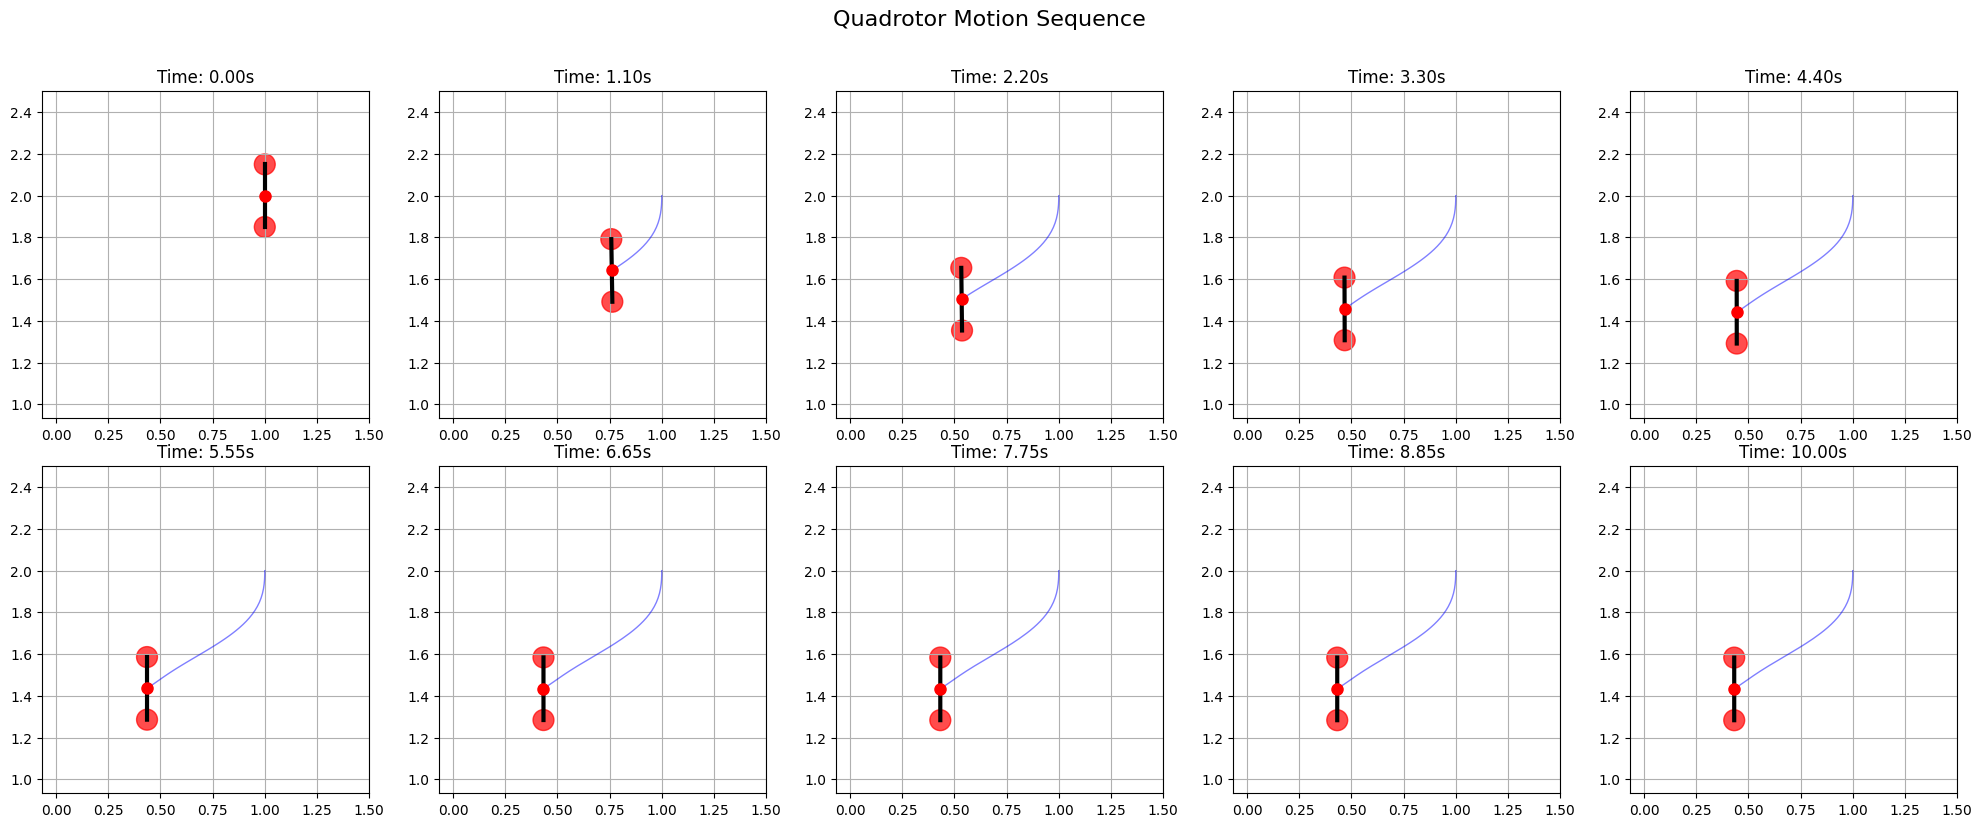

Showing LQR vs MPC comparison...


IndexError: index 4 is out of bounds for axis 1 with size 4

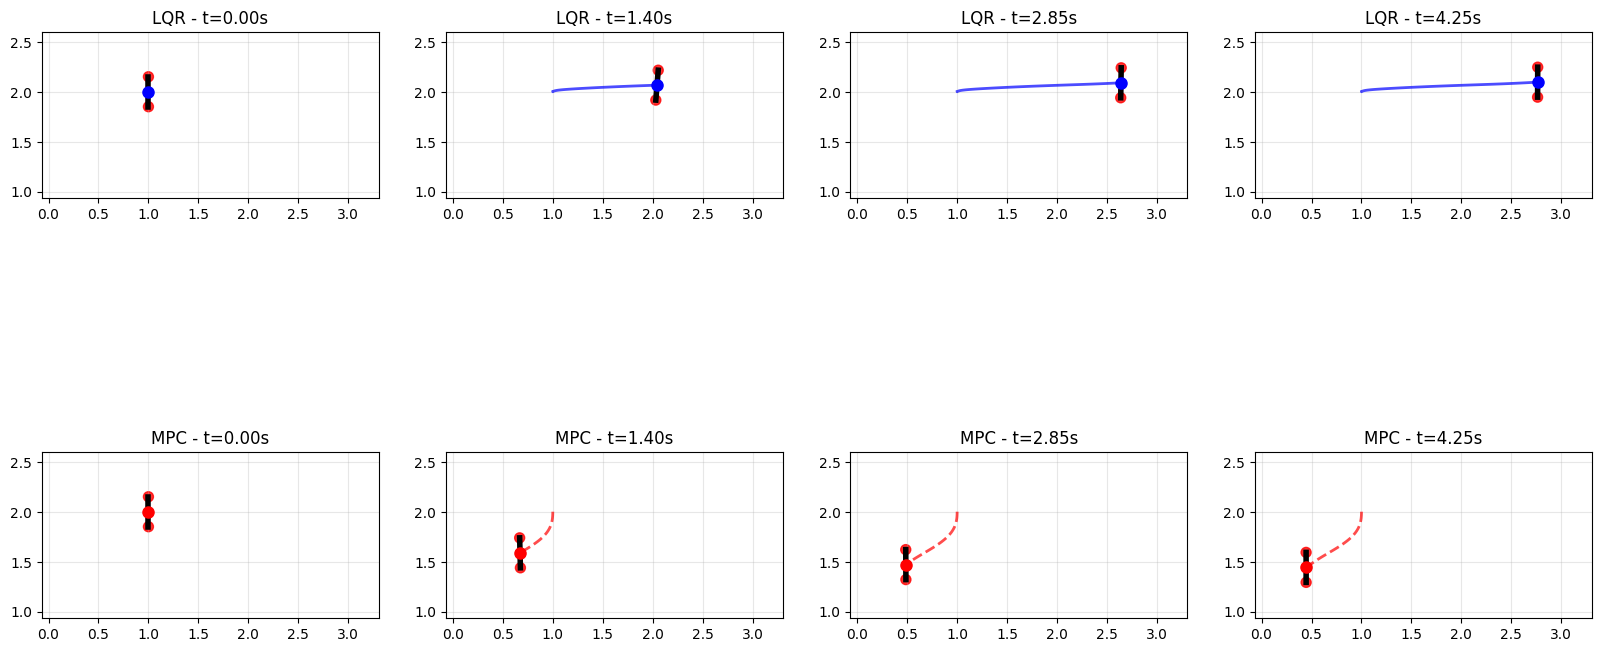

In [37]:
print("Creating MPC animation...")
anim_mpc = QuadrotorAnimator(xhist2, thist)

# Show static frames
print("Showing MPC static frames...")
anim_mpc.create_static_frames()

# Show comparison between LQR and MPC
print("Showing LQR vs MPC comparison...")
anim_lqr.create_comparison_animation_frames(anim_mpc)

# Optional: save as GIF (uncomment to use)
# anim_mpc.animate(save_gif=True, filename='mpc_animation.gif')

In [38]:
# Performance comparison
print("=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

# Calculate costs
lqr_cost = cost(xhist1, uhist1)
mpc_cost = cost(xhist2, uhist2)

print(f"LQR Cost: {lqr_cost:.4f}")
print(f"MPC Cost: {mpc_cost:.4f}")
print(f"Cost Improvement (MPC vs LQR): {((lqr_cost - mpc_cost) / lqr_cost * 100):.2f}%")

# Calculate final errors
lqr_final_error = np.linalg.norm(xhist1[:, -1] - x_ref)
mpc_final_error = np.linalg.norm(xhist2[:, -1] - x_ref)

print(f"\nFinal tracking error:")
print(f"LQR: {lqr_final_error:.4f}")
print(f"MPC: {mpc_final_error:.4f}")

# Calculate settling times (time to reach within 5% of reference)
def settling_time(xhist, x_ref, threshold=0.05):
    error = np.linalg.norm(xhist - x_ref.reshape(-1, 1), axis=0)
    ref_norm = np.linalg.norm(x_ref)
    settled_indices = np.where(error < threshold * ref_norm)[0]
    if len(settled_indices) > 0:
        return thist[settled_indices[0]]
    else:
        return float('inf')

lqr_settling = settling_time(xhist1, x_ref)
mpc_settling = settling_time(xhist2, x_ref)

print(f"\nSettling time (5% threshold):")
print(f"LQR: {lqr_settling:.2f}s")
print(f"MPC: {mpc_settling:.2f}s")

# Control effort
lqr_control_effort = np.sum(np.linalg.norm(uhist1, axis=0))
mpc_control_effort = np.sum(np.linalg.norm(uhist2, axis=0))

print(f"\nTotal control effort:")
print(f"LQR: {lqr_control_effort:.2f}")
print(f"MPC: {mpc_control_effort:.2f}")

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print("The MPC controller explicitly handles constraints and uses a finite")
print("horizon optimization, which can lead to better performance in")
print("constrained scenarios. The LQR controller is simpler and faster")
print("to compute but may violate constraints.")

PERFORMANCE COMPARISON
LQR Cost: 1171.2413
MPC Cost: 307.5422
Cost Improvement (MPC vs LQR): 73.74%

Final tracking error:
LQR: 3.4740
MPC: 1.8371

Settling time (5% threshold):
LQR: infs
MPC: infs

Total control effort:
LQR: 1389.31
MPC: 1387.60

SUMMARY
The MPC controller explicitly handles constraints and uses a finite
horizon optimization, which can lead to better performance in
constrained scenarios. The LQR controller is simpler and faster
to compute but may violate constraints.
